In [1]:
import pandas as pd
from pandas_profiling import ProfileReport
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import plotly
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from tqdm.notebook import tqdm as tqdm

import holidays
from datetime import date

import pywt


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
"""
Aux functions
"""

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics: 
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

'\nAux functions\n'

In [14]:
"""
Reading dataframes

"""

INPUT_DIR_PATH = ''
DAYS_PRED = 28
DATASET_SIZE = 1947
TR_LAST = DATASET_SIZE - 28 - 28
VL_LAST = DATASET_SIZE - 28
TS_LAST = DATASET_SIZE

def read_data():
    sell_prices_df = pd.read_csv(INPUT_DIR_PATH + 'sell_prices.csv')
    sell_prices_df = reduce_mem_usage(sell_prices_df)
    print('Sell prices has {} rows and {} columns'.format(sell_prices_df.shape[0], sell_prices_df.shape[1]))

    calendar_df = pd.read_csv(INPUT_DIR_PATH + 'calendar.csv')
    calendar_df = reduce_mem_usage(calendar_df)
    calendar_df = calendar_df.fillna('unknown')
    print('Calendar has {} rows and {} columns'.format(calendar_df.shape[0], calendar_df.shape[1]))

    sales_df = pd.read_csv(INPUT_DIR_PATH + 'sales_train_evaluation.csv')
    print('Sales train validation has {} rows and {} columns'.format(sales_df.shape[0], sales_df.shape[1]))

    submission_df = pd.read_csv(INPUT_DIR_PATH + 'sample_submission.csv')
    return sell_prices_df, calendar_df, sales_df, submission_df
    
prices_df, calendar_df, sales_df, submission_df = read_data()

num_cols = [f"d_{day}" for day in range(0,TR_LAST+1)]
cat_cols = ['id', 'item_id', 'dept_id','store_id', 'cat_id', 'state_id']

df = pd.melt(sales_df,
                  id_vars = cat_cols,
                  value_vars = [col for col in sales_df.columns if col.startswith("d_")],
                  var_name = "d",
                  value_name = "sales")

df = df.merge(calendar_df, on= "d", copy = False)
df = df.merge(prices_df, on = ["store_id", "item_id", "wm_yr_wk"], copy = False)
del sales_df, calendar_df, prices_df
# gc.collect()

df_raw = df.copy()

'\nReading dataframes\n\n'

Mem. usage decreased to 130.48 Mb (37.5% reduction)
Sell prices has 6841121 rows and 4 columns
Mem. usage decreased to  0.12 Mb (41.9% reduction)
Calendar has 1969 rows and 14 columns
Sales train validation has 30490 rows and 1947 columns


In [ ]:
"""
EDA - https://www.kaggle.com/headsortails/back-to-predict-the-future-interactive-m5-eda
"""
print('Descriptive Statistics for Item prices by Store')
prices_df.groupby(['store_id','item_id'])['sell_price'].agg(['min', 'max', 'mean', 'count']).head(20)

# Zeros Distribution

data_sample = sales_train_validation.loc[:,days].T
dist = (data_sample==0).sum()
hist_data = [dist]
group_labels = ['Zero Sale distribution']
fig = ff.create_distplot(hist_data, group_labels)
fig.update_layout(autosize=False, width=800, height=500, margin=dict(l=10, r=10, b=10, t=40))
fig.update_layout(template='plotly_dark', title_text='Zero Sale Days distribution')
fig.show()

# Ones sales distribution
data_sample = sales_train_validation.loc[:,days].T
dist = (data_sample==1).sum()
hist_data = [dist]
group_labels = ['One Sale distribution']
fig = ff.create_distplot(hist_data, group_labels)
fig.update_layout(autosize=False, width=800, height=500, margin=dict(l=10, r=10, b=10, t=40))
fig.update_layout(template='plotly_dark', title_text='One Sale Days distribution')
fig.show()


# Interactive viz
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

df = pd.read_csv(INPUT_DIR_PATH + 'sales_train_evaluation.csv')

sales_sum_by_store = df.groupby(['store_id']).sum().T.reset_index(drop = True)
sales_mean_by_store = df.groupby(['store_id']).mean().T.reset_index(drop = True) 

print('Sales aggregated by different Stores')
df.iplot(kind='box',  margin=(10, 10, 10, 40) ,dimensions=(900,500), title = 'Total Sales by Store ID', xTitle = 'Store ID', yTitle = 'Total Sales')
df.iplot(kind='box',  margin=(10, 10, 10, 40) ,dimensions=(900,500), title = 'Average Sales by Store ID', xTitle = 'Store ID', yTitle = 'Average Sales')

In [ ]:
df = df_raw
df = df.groupby('date').sum()
df['sales'].T.plot(figsize=(30,5))

In [ ]:
"""
Adding exonerous variables:
- Feature Engineering
- Events and holidays

Note: similar to a new feature in regular ML models

Date       |  Y  |   Weekday   |   Avg_sales_7_lags   |   price_increased   |   is_game_night   |   (...)  |
____________________________________________________________________________________________________________
1-1-2014   |  7  |      2      |          6.2         |        'y'          |        'n'        |   (...)  |
2-1-2014   |  6  |      3      |          6.1         |        'n'          |        'y'        |   (...)  |

  (...)    |(...)|    (...)    |         (...)        |        (...)        |        (...)      |   (...)  |
____________________________________________________________________________________________________________  
1-5-2020.  |  ?  |      6      |          7.2         |        'n'          |        'y'        |   (...)  |

"""

years = [year for year in range(2012, 2021)]

us_holidays = holidays.US(state='CA', years = years) + holidays.US(state='TX', years = years) + holidays.US(state='WI', years = years)

# Customized holidays:

customized_holidays = {"2020-06-29": "Today's day",
                      "2020-06-30": "International day of Tomorrow"}

# us_holidays
us_holidays.append(customized_holidays)


In [ ]:
"""
Feature Engineering

Dates, pricesm etc, of previous X days, same category, same state, etc..
"""
 # rolling demand features
    
for val in range(1, 30):
    df[f"shift_t{val}"] = df.groupby(["id"])["demand"].transform(lambda x: x.shift(val))
for val in range(1, 30):
    df[f"rolling_std_t{val}"] = df.groupby(["id"])["demand"].transform(lambda x: x.shift(28).rolling(val).std())
for val in range(1, 30):
    df[f"rolling_mean_t{val}"] = df.groupby(["id"])["demand"].transform(lambda x: x.shift(28).rolling(val).mean())

df["rolling_skew_t30"] = df.groupby(["id"])["demand"].transform( lambda x: x.shift(28).rolling(30).skew())
df["rolling_kurt_t30"] = df.groupby(["id"])["demand"].transform(lambda x: x.shift(28).rolling(30).kurt())

# price features
df['lag_price_t1'] = df.groupby(['id'])['sell_price'].transform(lambda x: x.shift(1))
df['price_change_t1'] = (df['lag_price_t1'] - df['sell_price']) / (df['lag_price_t1'])
df['rolling_price_max_t365'] = df.groupby(['id'])['sell_price'].transform(lambda x: x.shift(1).rolling(365).max())
df['price_change_t365'] = (df['rolling_price_max_t365'] - df['sell_price']) / (df['rolling_price_max_t365'])
df['rolling_price_std_t7'] = df.groupby(['id'])['sell_price'].transform(lambda x: x.rolling(7).std())
df['rolling_price_std_t30'] = df.groupby(['id'])['sell_price'].transform(lambda x: x.rolling(30).std())
df.drop(['rolling_price_max_t365', 'lag_price_t1'], inplace = True, axis = 1)
    
# time features
df['date'] = pd.to_datetime(df['date'])
attrs = ["year", "quarter", "month", "week", "day", "dayofweek", "is_year_end", "is_year_start", "is_quarter_end", \
    "is_quarter_start", "is_month_end","is_month_start",
]

for attr in attrs:
    dtype = np.int16 if attr == "year" else np.int8
    df[attr] = getattr(df['date'].dt, attr).astype(dtype)
df["is_weekend"] = df["dayofweek"].isin([5, 6]).astype(np.int8)





COLUMN_1 = [14, 30, 61, 121, 182, 365] # [14, 30, 60, 120, 180, 360] -> it is what everyobe uses, doesnt make sense...
COLUMN_2 = [7, 14, 28, 56]
for i in COLUMN_1:
    df[f'rolling_mean{i}'] = df.groupby(['id'])['d_1'].transform(lambda x: x.shift(28).rolling(i).mean())    
    df[f'rolling_std{i}'] = df.groupby(['id'])['d_1'].transform(lambda x: x.shift(28).rolling(i).std()) 

for i in range(1, 58):
    df['lag_t14'] = df.groupby(['id'])[f'd_{i}'].transform(lambda x: x.shift(14))
    df['lag_t7'] = df.groupby(['id'])[f'd_{i}'].transform(lambda x: x.shift(7))
    df['lag_t28'] = df.groupby(['id'])[f'd_{i}'].transform(lambda x: x.shift(28))
    df['lag_t56'] = df.groupby(['id'])[f'd_{i}'].transform(lambda x: x.shift(56))
    df['stddev'] = df.groupby(['id'])[f'd_{i}'].transform('std')
    df['lag_t14'] = df.groupby(['id'])[f'd_{i}'].transform(lambda x: np.std(x.shift(14)))
    df['lag_t7'] = df.groupby(['id'])[f'd_{i}'].transform(lambda x: np.std(x.shift(7)))
    df['lag_t28'] = df.groupby(['id'])[f'd_{i}'].transform(lambda x: np.std(x.shift(28)))
    df['lag_t56'] = df.groupby(['id'])[f'd_{i}'].transform(lambda x: np.std(x.shift(56)))

for i in range(1, 58):
    df['fourier_lag_t14'] = df.groupby(['id'])[f'd_{i}'].transform(lambda x: np.fft.fft(x.shift(14)))
    df['fourier_lag_t7'] = df.groupby(['id'])[f'd_{i}'].transform(lambda x: np.fft.fft(x.shift(7)))
    df['fourier_lag_t28'] = df.groupby(['id'])[f'd_{i}'].transform(lambda x: np.fft.fft(x.shift(28)))
    df['fourier_lag_t56'] = df.groupby(['id'])[f'd_{i}'].transform(lambda x: np.fft.fft(x.shift(56)))

    df['ifourier_lag_t14'] = df.groupby(['id'])[f'd_{i}'].transform(lambda x: np.fft.ifft(x.shift(14)))
    df['ifourier_lag_t7'] = df.groupby(['id'])[f'd_{i}'].transform(lambda x: np.fft.ifft(x.shift(7)))
    df['ifourier_lag_t28'] = df.groupby(['id'])[f'd_{i}'].transform(lambda x: np.fft.ifft(x.shift(28)))
    df['ifourier_lag_t56'] = df.groupby(['id'])[f'd_{i}'].transform(lambda x: np.fft.ifft(x.shift(56)))

    df['dfourier_lag_t14'] = df.groupby(['id'])[f'd_{i}'].transform(lambda x: scipy.fft.dct(x.shift(14), type=2, norm='ortho'))
    df['dfourier_lag_t7'] = df.groupby(['id'])[f'd_{i}'].transform(lambda x: scipy.fft.dct(x.shift(7), type=2, norm='ortho'))
    df['dfourier_lag_t28'] = df.groupby(['id'])[f'd_{i}'].transform(lambda x: scipy.fft.dct(x.shift(28), type=2, norm='ortho'))
    df['dfourier_lag_t56'] = df.groupby(['id'])[f'd_{i}'].transform(lambda x: scipy.fft.dct(x.shift(56), type=2, norm='ortho'))

    df['idfourier_lag_t14'] = df.groupby(['id'])[f'd_{i}'].transform(lambda x: scipy.fft.idct(x.shift(14), type=2, norm='ortho'))
    df['idfourier_lag_t7'] = df.groupby(['id'])[f'd_{i}'].transform(lambda x: scipy.fft.idct(x.shift(7), type=2, norm='ortho'))
    df['idfourier_lag_t28'] = df.groupby(['id'])[f'd_{i}'].transform(lambda x: scipy.fft.idct(x.shift(28), type=2, norm='ortho'))
    df['idfourier_lag_t56'] = df.groupby(['id'])[f'd_{i}'].transform(lambda x: scipy.fft.idct(x.shift(56), type=2, norm='ortho'))

    df['dsfourier_lag_t14'] = df.groupby(['id'])[f'd_{i}'].transform(lambda x: scipy.fft.dst(x.shift(14), type=2, norm='ortho'))
    df['dsfourier_lag_t7'] = df.groupby(['id'])[f'd_{i}'].transform(lambda x: scipy.fft.dst(x.shift(7), type=2, norm='ortho'))
    df['dsfourier_lag_t28'] = df.groupby(['id'])[f'd_{i}'].transform(lambda x: scipy.fft.dst(x.shift(28), type=2, norm='ortho'))
    df['dsfourier_lag_t56'] = df.groupby(['id'])[f'd_{i}'].transform(lambda x: scipy.fft.dst(x.shift(56), type=2, norm='ortho'))

    df['idfourier_lag_t14'] = df.groupby(['id'])[f'd_{i}'].transform(lambda x: scipy.fft.idst(x.shift(14), type=2, norm='ortho'))
    df['idfourier_lag_t28'] = df.groupby(['id'])[f'd_{i}'].transform(lambda x: scipy.fft.idst(x.shift(28), type=2, norm='ortho'))
    df['idfourier_lag_t56'] = df.groupby(['id'])[f'd_{i}'].transform(lambda x: scipy.fft.idst(x.shift(56), type=2, norm='ortho'))
    
df['price_max'] = df.groupby(['store_id','item_id'])['sell_price'].transform('max')
df['price_min'] = df.groupby(['store_id','item_id'])['sell_price'].transform('min')
df['price_std'] = df.groupby(['store_id','item_id'])['sell_price'].transform('std')
df['price_mean'] = df.groupby(['store_id','item_id'])['sell_price'].transform('mean')


# percentage change between the current and a prior element
df["sell_price_rel_diff"] = df.groupby(["item_id"])["sell_price"].pct_change()

# rolling std of prices
df["sell_price_roll_sd7"] = df.groupby(["item_id"])["sell_price"].transform(lambda x: x.rolling(7).std())

# relative cumulative price 
grouped = df.groupby(["item_id"])["sell_price"]
df["sell_price_cumrel"] = (grouped.shift(0) - grouped.cummin()) / (1 + grouped.cummax() - grouped.cummin())

# Some items are can be inflation dependent
# and some items are very "stable"
prices_df['price_nunique'] = prices_df.groupby(['store_id','item_id'])['sell_price'].transform('nunique')
prices_df['item_nunique'] = prices_df.groupby(['store_id','sell_price'])['item_id'].transform('nunique')


# Now we can add price "momentum" (some sort of)
# Shifted by week 
# by month mean
# by year mean
prices_df['price_momentum'] = prices_df['sell_price']/prices_df.groupby(['store_id','item_id'])['sell_price'].transform(lambda x: x.shift(1))
prices_df['price_momentum_m'] = prices_df['sell_price']/prices_df.groupby(['store_id','item_id','month'])['sell_price'].transform('mean')
prices_df['price_momentum_y'] = prices_df['sell_price']/prices_df.groupby(['store_id','item_id','year'])['sell_price'].transform('mean')

In [ ]:
"""
Encodings

Add:
Circle Encoding
Target Encoding
Etc..

"""
def circle_encode(df, col):

    maxval = float(df[col].max())
    
    cosval = np.cos(2 * np.pi * df[col]/maxval)
    sinval = np.sin(2 * np.pi * df[col]/maxval)

    return cosval, sinval

## Adding the embedded vectors 
df['wd1'] =0
df['wd2'] =0
df['wd3'] =0
df['wd4'] =0

df.loc[:,'wd1'][df['weekday'] =='Sunday'] , df.loc[:,'wd2'][df['weekday'] =='Sunday'],\
df.loc[:,'wd3'][df['weekday'] =='Sunday'] , df.loc[:,'wd4'][df['weekday'] =='Sunday']= 0.4 ,-0.3 ,0.6,0.1

df.loc[:,'wd1'][df['weekday'] =='Monday'] , df.loc[:,'wd2'][df['weekday'] =='Monday'],\
df.loc[:,'wd3'][df['weekday'] =='Monday'] , df.loc[:,'wd4'][df['weekday'] =='Monday']= 0.2 ,0.2 ,0.5,-0.3

df.loc[:,'wd1'][df['weekday'] =='Tuesday'] ,df.loc[:,'wd2'][df['weekday'] =='Tuesday'],\
df.loc[:,'wd3'][df['weekday'] =='Tuesday'] , df.loc[:,'wd4'][df['weekday'] =='Tuesday']= 0.1,-1.0,1.3,0.9

df.loc[:,'wd1'][df['weekday'] =='Wednesday'] , df.loc[:,'wd2'][df['weekday'] =='Wednesday'],\
df.loc[:,'wd3'][df['weekday'] =='Wednesday'] , df.loc[:,'wd4'][df['weekday'] =='Wednesday']= -0.6,0.5,1.2,0.7

df.loc[:,'wd1'][df['weekday'] =='Thursday'] , df.loc[:,'wd2'][df['weekday'] =='Thursday'],\
df.loc[:,'wd3'][df['weekday'] =='Thursday'] , df.loc[:,'wd4'][df['weekday'] =='Thursday']= 0.9,0.2,-0.1,0.6

df.loc[:,'wd1'][df['weekday'] =='Friday'] , df.loc[:,'wd2'][df['weekday'] =='Friday'],\
df.loc[:,'wd3'][df['weekday'] =='Friday'] , df.loc[:,'wd4'][df['weekday'] =='Friday']= 0.4,1.1,0.3,-1.5


df.loc[:,'wd1'][df['weekday'] =='Saturday'] , df.loc[:,'wd2'][df['weekday'] =='Saturday'],\
df.loc[:,'wd3'][df['weekday'] =='Saturday'] , df.loc[:,'wd4'][df['weekday'] =='Saturday']= 0.3,-0.2,0.6,0.0

def encode_categorical(df, cols):
    for col in cols:
        # Leave NaN as it is.
        le = preprocessing.LabelEncoder()
        not_null = df[col][df[col].notnull()]
        df[col] = pd.Series(le.fit_transform(not_null), index=not_null.index)

    return df


calendar_df = encode_categorical(calendar_df, ["event_name_1", "event_type_1", "event_name_2", "event_type_2"]).pipe(reduce_mem_usage)
sales_train_validation_df = encode_categorical(sales_train_validation_df, ["item_id", "dept_id", "cat_id", "store_id", "state_id"]).pipe(reduce_mem_usage)
sell_prices_df = encode_categorical(sell_prices_df, ["item_id", "store_id"]).pipe(reduce_mem_usage)


In [ ]:
"""
Data preparation

1. Null  -> Do nothing
2. Zeros and negatives-> Convert to NA
3. Outliers - Explain or convert to NA
4. Transformations

"""
df['sales'] = df['sales'].replace(0, np.nan)  #not working........
# or
# df['y'] = np.where(df['y'] <=0, np.nan)    #not working........


from scipy import stats
df = df[df['sales'].between(df['sales'].quantile(.05), df['sales'].quantile(.95))]
df['sales'].T.plot(figsize=(30,5))


nan_features_cat = ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
for feature in nan_features_cat:
    df[feature].fillna('unknown', inplace = True)

data['sell_price'].fillna(0, inplace = True)

In [ ]:
"""
Check if the wave is stationary

Needs to have constant mean (dont have any trend related to time)
Constant variance (homoscedascity, amplitude doesn't change with time)
Constant autocorrelation (frequency of the wave should be constant)

Dickey-Fuller test says that if 'Test Statistic' is greater than the 'Critical Value', it means the time series is stationary.


The smaller the p-value, the more likely to be stationary.

To get stationary data, we can apply transformations like log, differencing, etc..
"""

from statsmodels.tsa.stattools import adfuller

#1
adf, pvalue, usedlag_, nobs_, critical_values_, icbest_ = adfuller(df['sales'])

print("")
print(f'adf (Test Statistic) is: {adf}')
print(f'p-value is: {pvalue}')
print(f'usedlag_ is: {usedlag_}')
print(f'nobs_ is: {nobs_}')
print(f'critical_values_ is: {critical_values_}')
print(f'icbest_ is: {icbest_}')
print("")


#2
res = sm.tsa.adfuller(df['sales'].dropna(),regression='ct')
print('p-value:{}'.format(res[1]))

res = sm.tsa.adfuller(df['sales'].diff().dropna(),regression='c')
print('p-value:{}'.format(res[1]))
print("")
print("")


#3
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
tsplot(df['sales'], lags=60)

# Augmented Dickey-Fuller test #4
adf1 = adfuller(df, autolag='AIC')
print("p-value of Foods serie is: {}".format(float(adf1[1])))

In [ ]:
res = sm.tsa.seasonal_decompose(df['sales'],period=1) # , model='multiplicative'
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

In [ ]:
"""
Denoising the signal using Wavelet
"""

def maddest(d, axis=None):
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def denoise_signal(x, wavelet='db4', level=1):
    coeff = pywt.wavedec(x, wavelet, mode="per")
    sigma = (1/0.6745) * maddest(coeff[-level])

    uthresh = sigma * np.sqrt(2*np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])

    return pywt.waverec(coeff, wavelet, mode='per')

wavelet_y = denoise_signal(df['sales'])

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(30, 20))

ax[0, 0].plot(df['sales'], color='seagreen', marker='o') 
ax[0, 0].set_title('Original Sales', fontsize=24)
ax[0, 1].plot(wavelet_y, color='red', marker='.') 
ax[0, 1].set_title('After Wavelet Denoising', fontsize=24)

plt.show()

df['sales'] = wavelet_y

In [ ]:
wavelet_y.shape
df.shape

In [ ]:
"""
Average Smoothing to reduce more noise
"""

def average_smoothing(signal, kernel_size=3, stride=1):
    sample = []
    start = 0
    end = kernel_size
    while end <= len(signal):
        start = start + stride
        end = end + stride
        sample.extend(np.ones(end - start)*np.mean(signal[start:end]))
    return np.array(sample)


smoothing_y = average_smoothing(df['sales'])



fig = make_subplots(rows=2, cols=1)



fig.add_trace(go.Scatter(x=np.arange(len(df['sales'])), y=df['sales'], showlegend=False,
                    mode='lines+markers', name="First sample",
                         marker=dict(color="mediumseagreen")),
             row=1, col=1)

fig.add_trace(go.Scatter(x=np.arange(len(df['sales'])), y=smoothing_y, showlegend=False,
                    mode='lines+markers', name="First sample",
                         marker=dict(color="black")),
             row=1, col=1)

# df['sales'] = smoothing_y

In [ ]:
"""
To create models and optimize the SARIMAX parameters
Split in Train/Validation
"""

import matplotlib.pyplot as plt
import statsmodels.api as sm


train = df['y']

fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(train, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(train, lags=50, ax=ax[1])
plt.show()

In [ ]:
"""
Auto tune parameters

How to evaluate the best.. MSE or AIC?


p is the first most significant negative value in PACF
d
q is the first most significant negative value in ACF
"""
import itertools
#set parameter range
p = range(0,3)
q = range(1,3)
d = range(1,2)
s = range(7,8)

# list of all parameter combos
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(p, d, q, s))

results = []
best_aic = float("inf")

print(pdq)
print(seasonal_pdq)
# SARIMA model pipeline
for param in tqdm_notebook(pdq):
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(endog=df['sales'],
                                    order=param,
                                    seasonal_order=param_seasonal,
                                    enforce_stationary=False,
                                    enforce_invertibility=False,
                                    time_varying_regression = False,
                                    mle_regression = True)
            result = mod.fit(max_iter = 50, method = 'powell')
            results.append(result)
            print('SARIMA{},{} - AIC:{}'.format(param, param_seasonal, result.aic))
        except:
            continue
            
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
# sorting in ascending order, the lower AIC is - the better
result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
result_table.head()

In [ ]:
# According Peterson, T. (2014) the AIC (Akaike information criterion) is an estimator of the relative quality of statistical models for a given set of data. 
# Given a collection of models for the data, AIC estimates the quality of each model, relative to each of the other models. The low AIC value the better.

print(result_table.parameters[0])

best_model=sm.tsa.statespace.SARIMAX(df['demand'], 
                                     order=(p, d, q),
                                     seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

In [ ]:
# Having a low autocorrelation in resid means that ou model is good


res = best_model.resid
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(res, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=50, ax=ax[1])
plt.show()


In [ ]:
mae_sarima = np.mean(np.abs(res))
print('Mean absolute error: ', mae_sarima)
result.summary()
result.plot_diagnostics(figsize=(15, 12))

In [ ]:
# In this model's summary, Jarque-Bera test's Prob is under 0.05.
# It means that this model's resid is not following a normal distribution.
# In other words, some infomations still remain in this model's resid.

# Also, look at skewness in the histogram

<!-- In this model's summary, Jarque-Bera test's Prob is under 0.05.
It means that this model's resid is not following a normal distribution.
In other words, some infomations still remain in this model's resid. -->

In [ ]:
from sklearn.metrics import mean_squared_error
pred = result.predict()[1:]
print('ARIMA model MSE:{}'.format(mean_squared_error(tes,pred)))

In [ ]:
"""
Training model
"""

p =
d =
q =
S =

model = sm.tsa.statespace.SARIMAX(train, order=(p,d,q), 
                                  seasonal_order(p,d,q,S),
                                 holidays)
                                 .fit(max_iter=50, method='powell')
res = model.resid
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(res, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=50, ax=ax[1])
plt.show()




In [ ]:
"""
Use Walk Forward Validation to validate the model
"""

# data = entire dataset
# n_test = point where data is split into training and test sets
def walk_forward_validation(data, n_test):
    predictions = np.array([])
    mape_list = []
    train, test = data[:n_test], data[n_test:]
    day_list = [7,14,21,28] # weeks 1,2,3,4
    for i in day_list:
        # Fit model to training data
        model = sm.tsa.statespace.SARIMAX(train, order=(1,1,2), seasonal_order=(1,1,2,7)).fit(max_iter = 50,
                                          method = 'powell')
        
        # Forecast daily loads for week i
        forecast = model.get_forecast(steps = 7)
        predictions = np.concatenate(predictions, forecast, 
                                     axis=None)
        # Calculate MAPE and add to mape_list
        j = i-7
        mape_score = (abs(test[j:i]-predictions[j:i])/test[j:i])*100
        mape_mean = mape_score.mean()
        mape_list.append(mape_mean)
        # Add week i to training data for next loop
        train = np.concatenate((train, test[j:i]), axis=None)
    return predictions, mape_list

In [ ]:
pred, mape_list = walk_forward_validation(df['y'], 1913)

In [ ]:
# Predictions example

train_dataset = df[:-56]
val_dataset = df[-56:]

predictions = []
for row in tqdm(train_dataset[train_dataset.columns[-30:]].values):
    fit = sm.tsa.statespace.SARIMAX(row, seasonal_order=(0, 1, 1, 7), initialization='approximate_diffuse').fit()
    predictions.append(fit.forecast(3))
predictions = np.array(predictions)
error_arima = np.linalg.norm(predictions - val_dataset.values)/len(predictions[0])

Cool Details

Analysing stockouts
https://www.kaggle.com/jpmiller/grouping-items-by-stockout-pattern

Wavelet Denoising
https://www.kaggle.com/eswarchandt/timeseries-forecasting-accuracy

Advanced Transformations
https://www.kaggle.com/rdizzl3/time-series-transformations

Croston Model
https://www.kaggle.com/siavrez/simple-eda-with-croston-method

WRMSSE Evaluation
https://www.kaggle.com/sibmike/fast-clear-wrmsse-18ms

LGBM GroupKFold CV
https://www.kaggle.com/ragnar123/simple-lgbm-groupkfold-cv

Dates Feataure Engineering
https://www.kaggle.com/raenish/cheatsheet-date-helpers

All ML models
https://www.kaggle.com/rodrigolima82/time-series-analysis-es-sarimax-xgb-lgbm#Kaggle-Competition:-M5-Forecasting

MAPA methodology
https://www.kaggle.com/brunoborges95/m5-time-series-forecasting-using-mapa-sarimax

Deep Neural Nets approach
https://www.kaggle.com/timetraveller98/m5-accuracy-pytorch-deep-neural-net-dnn

LSTM Simple approach
https://www.kaggle.com/eakdag/lstm-with-keras-0-7

Prophet approach
https://www.kaggle.com/ritvik29/fb-prophet-compile-codes-june16

Clustering Items
https://www.kaggle.com/ry2m2t/m5-clustering-items-dft-pca-t-sne-dbscan-en-jp

TBATS to use multiple seasonalities in SARIMAX
https://medium.com/intive-developers/forecasting-time-series-with-multiple-seasonalities-using-tbats-in-python-398a00ac0e8a


Parallelize training

Interactive plots




Why ML is not so well suited as arima? eg Gauss Markov Theorem

In LGBM convert df to matrix before training 
from scipy import sparse 
temp_matrix = sparse.csr_matrix(temp_df)

Pipeline

Import datasets, reduce mem, merge them
Data cleaning
Making the wave stationary ('sales'), using
Feature engineering
Encoding
Feature transformations, normalizations
Training
Validating
HP optimization
Predicting


Features
is_vespera_feriado
consecutive_zeros


In [31]:


train = pd.read_csv('sales_train_evaluation.csv')
train['date'] = pd.to_datetime(train['date'], format="%Y-%m-%d")

train_df = train[train['store']==1]
train_df = train_df[train['item']==1]
# train_df = train_df.set_index('date')
train_df['year'] = train['date'].dt.year
train_df['month'] = train['date'].dt.month
train_df['day'] = train['date'].dt.dayofyear
train_df['weekday'] = train['date'].dt.weekday

train_df = train_df.set_index('date')
train_df['sales'] = train_df['sales'].astype(float)
df = df.groupby(['date', 'id']).sum().reset_index()
df.shape

(3, 1941)

In [69]:
df = df_raw
df['date'] = pd.to_datetime(df['date'], format="%Y-%m-%d")
df = df[df['store_id']=='CA_1']
df = df[df['item_id']=='HOBBIES_1_008']
df = df[['date', 'store_id', 'item_id', 'sales']]
df.head()

,date,store_id,item_id,sales
0,2011-01-29,CA_1,HOBBIES_1_008,12
1,2011-01-30,CA_1,HOBBIES_1_008,15
2,2011-01-31,CA_1,HOBBIES_1_008,0
3,2011-02-01,CA_1,HOBBIES_1_008,0
4,2011-02-02,CA_1,HOBBIES_1_008,0


In [70]:
df = pd.get_dummies(df)
df.head()

,date,sales,store_id_CA_1,item_id_HOBBIES_1_008
0,2011-01-29,12,1,1
1,2011-01-30,15,1,1
2,2011-01-31,0,1,1
3,2011-02-01,0,1,1
4,2011-02-02,0,1,1


In [72]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.dayofyear
df['weekday'] = df['date'].dt.weekday
df.head()

,date,sales,store_id_CA_1,item_id_HOBBIES_1_008,year,month,day,weekday
0,2011-01-29,12,1,1,2011,1,29,5
1,2011-01-30,15,1,1,2011,1,30,6
2,2011-01-31,0,1,1,2011,1,31,0
3,2011-02-01,0,1,1,2011,2,32,1
4,2011-02-02,0,1,1,2011,2,33,2


In [73]:
df = df.set_index('date')
df['sales'] = df['sales'].astype(float)
df.head()


,sales,store_id_CA_1,item_id_HOBBIES_1_008,year,month,day,weekday
date,,,,,,,
2011-01-29,12.0,1,1,2011,1,29,5
2011-01-30,15.0,1,1,2011,1,30,6
2011-01-31,0.0,1,1,2011,1,31,0
2011-02-01,0.0,1,1,2011,2,32,1
2011-02-02,0.0,1,1,2011,2,33,2


In [97]:
exog_data = df.drop(columns=['sales']).fillna('unknown')
exog_data = pd.get_dummies(exog_data)
exog_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1941 entries, 2011-01-29 to 2016-05-22
Columns: 508 entries, store_id_CA_1 to forecast_unknown
dtypes: int64(4), uint8(504)
memory usage: 1.1 MB


In [77]:
start_index = '2017-10-01'
end_index = '2017-12-31'

sarimax_mod6 = sm.tsa.statespace.SARIMAX(endog = df['sales'][:start_index],
                                        exog = exog_data[:start_index],  
                                        trend='n', order=(6,1,0), seasonal_order=(0,1,1,7)).fit()
print(sarimax_mod6.summary())

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


                                      SARIMAX Results                                      
Dep. Variable:                               sales   No. Observations:                 1941
Model:             SARIMAX(6, 1, 0)x(0, 1, [1], 7)   Log Likelihood               -8092.663
Date:                             Thu, 02 Jul 2020   AIC                          16213.326
Time:                                     09:12:37   BIC                          16291.262
Sample:                                 01-29-2011   HQIC                         16241.992
                                      - 05-22-2016                                         
Covariance Type:                               opg                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
store_id_CA_1         -1.084e-05      0.173  -6.28e-05      1.000      -0.339       

In [78]:
from scipy import stats
from scipy.stats import normaltest
resid = sarimax_mod6.resid
print(normaltest(resid))


# If pvalue of reuslt is very small it means that the residual is not a normal distribution
# If we observe a correlation between ACF and PACF it means we have seaasonality

NormaltestResult(statistic=4980.0386128802265, pvalue=0.0)


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/statespace/kalman_filter.py:2012: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


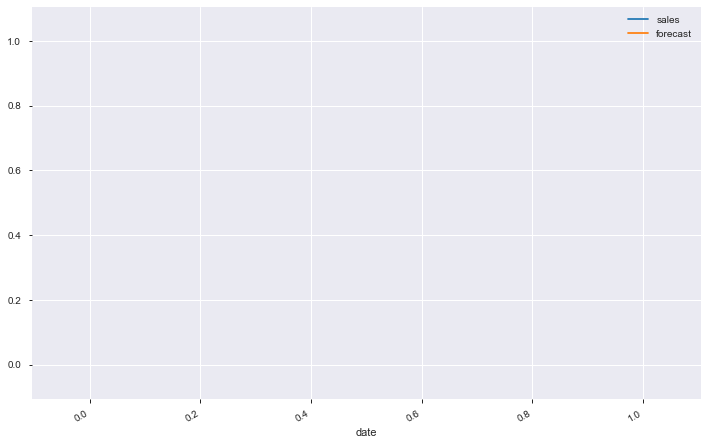

In [102]:
start_index = '2017-10-01'
end_index = '2017-12-31'
# sarimax_mod6.forecast(steps = 121,exog = exog_data[start_index:end_index])

df['forecast'] = sarimax_mod6.predict(start = start_index, 
                                      end= end_index, 
#                                       exog = exog_data[start_index:end_index], 
                                      dynamic= True)  

df[start_index:end_index][['sales', 'forecast']].plot(figsize=(12, 8))

In [103]:
mape = np.mean(abs((df['sales']-df['forecast'])/df['sales']))*100
smape = np.mean((np.abs(df['forecast'] - df['sales']) * 200/ (np.abs(df['forecast']) + np.abs(df['forecast']))).fillna(0))
print('MAPE: %.2f %% \nSMAPE: %.2f'% (mape,smape), "%")

MAPE: nan % 
SMAPE: 0.00 %


In [104]:
# Predictions example

train_dataset = df[:-28]
val_dataset = df[-28:]

predictions = []
for row in tqdm(train_dataset[2:][train_dataset.columns[-30:]].values):
    fit = sm.tsa.statespace.SARIMAX(row, seasonal_order=(0, 1, 1, 7), initialization='approximate_diffuse').fit()
    predictions.append(fit.forecast(3))
predictions = np.array(predictions)
error_arima = np.linalg.norm(predictions - val_dataset.values)/len(predictions[0])

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ValueError: operands could not be broadcast together with shapes (1911,3) (28,8) 